This example is based on the sklearn "[Manifold learning on Handwriting](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)" example. Let's start by loading some libraries and data.

This example was prepared by Yusuke Tomoto and Kyle McDonald for their
"Machine learning for ART" workshop at Rhizomatiks Research in
January, 2016.

In [0]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
%matplotlib inline

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

The data we loaded is a subset of MNIST, which contains 70k handwritten digits. We're only using around 1,000 digits. Here's what they look like:

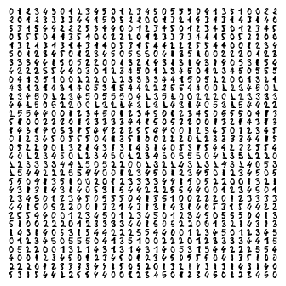

In [0]:
n_img_per_row = 32
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.show()

Manifold learning is about discovering a low-dimensional structure (also called a projection, decomposition, manifold, or embedding) for high-dimensional data.

Linear dimensionality reduction is the process of finding a projection. If your data existed in three dimensions and you wanted a two dimensional view, this would be similar to rotating or skewing the data until the shadow looked informative. PCA, LDA, and ICA find a rotation and skewing of the data that gives a good projection.

Before we look at these projections, we need to define a helper function that will plot the results of our projection.

In [0]:
def plot_embedding(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'size': 8})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
            
    plt.xticks([]), plt.yticks([])

Now we can find a projection and see what it looks like. The most common one is principle components analysis (PCA).

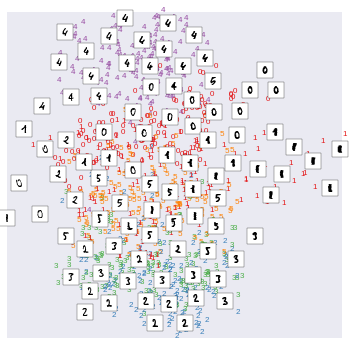

In [0]:
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca, y)

PCA is good at finding the main axes of variation in a dataset. Here it looks like it's separated the digits a little bit, but it's still hard to see the boundaries between them. One the other hand, linear discriminant analysis (LDA) will find a projection that maximally separates all the classes.

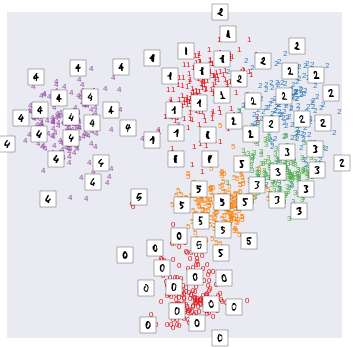

In [0]:
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda, y)

LDA can have great results, but if you look at the code it says `fit_transform(X2, y)` while PCA says `fit_transform(X)`. This means for LDA you need labeled data (supervised learning), but for PCA you can use unlabaled data (unsupervised learning). Here's a picture explaining the difference:

### PCA
[![](https://sebastianraschka.com/images/faq/lda-vs-pca/pca.png)](http://sebastianraschka.com/faq/docs/lda-vs-pca.html)

### LDA
[![](https://sebastianraschka.com/images/faq/lda-vs-pca/lda.png)](http://sebastianraschka.com/faq/docs/lda-vs-pca.html)

Independent components analysis (ICA) is like PCA in that it can be run without labels (unsupervised). Instead of the directions of maximum variance, it finds the directions in which the data varies most independently.

[![](http://phdthesis-bioinformatics-maxplanckinstitute-molecularplantphys.matthias-scholz.de/fig_pca_ica_independent_component_analysis.gif)](http://phdthesis-bioinformatics-maxplanckinstitute-molecularplantphys.matthias-scholz.de/#pca_ica_independent_component_analysis)
[![](http://gael-varoquaux.info/science/attachments/ica_pca/ica_on_non_gaussian_data.png)](http://gael-varoquaux.info/science/ica_vs_pca.html)

Here's what ICA looks like on the digits dataset:

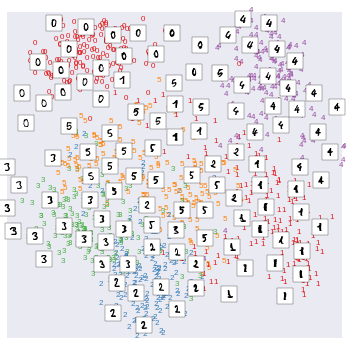

In [0]:
X_ica = decomposition.FastICA(n_components=2).fit_transform(X)
plot_embedding(X_ica, y)

The separation of the classes is closer to LDA than to PCA, but without any supervision. This isn't an inherent property of ICA or PCA, but it has more to do with the kind of data we're looking at.

Besides these linear techniques, there are others called "nonlinear dimensionality reduction algorithms". Instead of imagining the projection like a shadow, imagine each point in high dimensional space like a particle get pushed and pulled independently. The goal is usually to end up with an embedding that keeps similar points close by, distant points far apart, and maintains some locally continuous behavior of variation.

One of the most useful techniques for visualization purposes is called t-SNE ("tee snee"). A great paper showing comparisons is [here](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf). For a visualization of t-SNE see this [great article by Chris Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

CPU times: user 8.53 s, sys: 1.18 s, total: 9.71 s
Wall time: 9.5 s


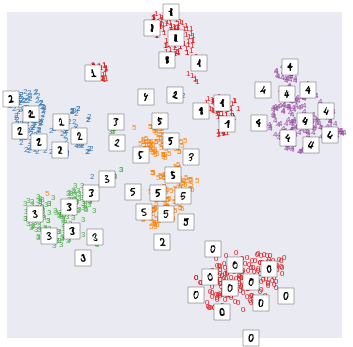

In [0]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
%time X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, y)

But there are many others with their own benefits and disavantages. For example, Isomap has a very impressive demo of being able to "unroll" an extruded spiral (called a "swiss roll"), and to project images of hands in two dimensions that capture the two ways the hand gestures vary.

![](http://web.mit.edu/cocosci/isomap/web1.jpg)

![](http://web.mit.edu/cocosci/isomap/web2.jpg)

CPU times: user 1.17 s, sys: 31 ms, total: 1.2 s
Wall time: 1.2 s


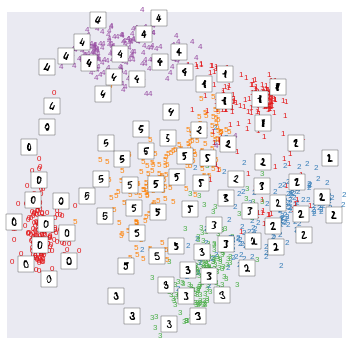

In [0]:
%time X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
plot_embedding(X_iso, y)

Some other algorithms are listed below.

CPU times: user 735 ms, sys: 351 ms, total: 1.09 s
Wall time: 636 ms


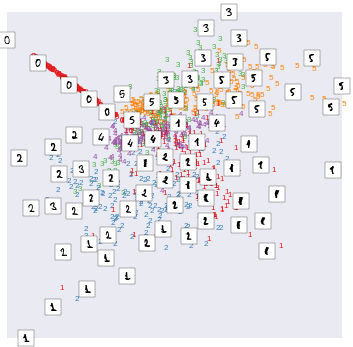

In [0]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='standard')
%time X_lle = clf.fit_transform(X)
plot_embedding(X_lle, y)

CPU times: user 1.11 s, sys: 558 ms, total: 1.67 s
Wall time: 990 ms


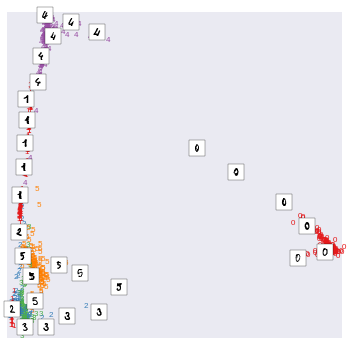

In [0]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='modified')
%time X_mlle = clf.fit_transform(X)
plot_embedding(X_mlle, y)

CPU times: user 1.59 s, sys: 916 ms, total: 2.51 s
Wall time: 1.36 s


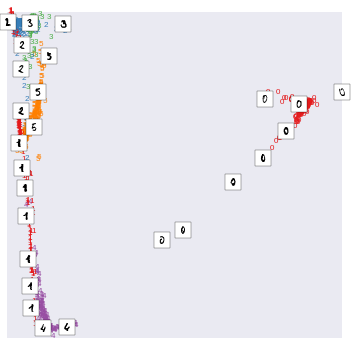

In [0]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='hessian')
%time X_hlle = clf.fit_transform(X)
plot_embedding(X_hlle, y)

CPU times: user 1.23 s, sys: 745 ms, total: 1.98 s
Wall time: 1.09 s


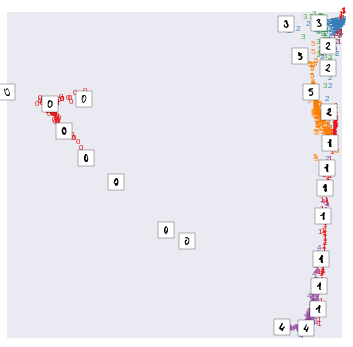

In [0]:
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='ltsa')
%time X_ltsa = clf.fit_transform(X)
plot_embedding(X_ltsa, y)

CPU times: user 4.14 s, sys: 2.47 s, total: 6.61 s
Wall time: 3.33 s


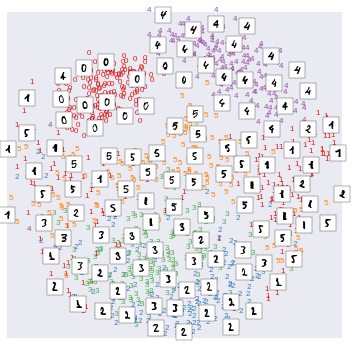

In [0]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
%time X_mds = clf.fit_transform(X)
plot_embedding(X_mds, y)

CPU times: user 635 ms, sys: 3 ms, total: 638 ms
Wall time: 640 ms
CPU times: user 79 ms, sys: 45 ms, total: 124 ms
Wall time: 70.4 ms


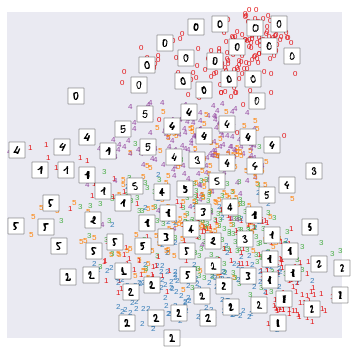

In [0]:
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0, max_depth=5)
%time X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
%time X_reduced = pca.fit_transform(X_transformed)
plot_embedding(X_reduced, y)

CPU times: user 541 ms, sys: 155 ms, total: 696 ms
Wall time: 502 ms


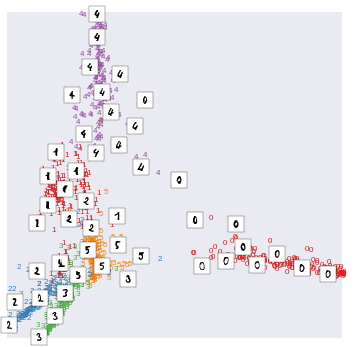

In [0]:
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack")
%time X_se = embedder.fit_transform(X)
plot_embedding(X_se, y)